[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/deJong_Mackay_et_al_2023/convergence.ipynb)

In [1]:
import os
# os.environ['NUMBA_NUM_THREADS'] = '10'
# os.environ['NVRTC_PATH'] ="/home/z1157095/anaconda3/envs/perf_comp/lib/python3.11/site-packages/nvidia/cuda_nvrtc/lib/libnvrtc.so.11.2"

In [2]:
from PySDM.backends.impl_thrust_rtc.conf import NICE_THRUST_FLAGS
NICE_THRUST_FLAGS

{'wait': False, 'debug_print': False}

In [3]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
#     pip_install_on_colab('PySDM-examples')

In [4]:
import os
from datetime import datetime
import json
from open_atmos_jupyter_utils import show_plot
import numpy as np
from matplotlib import pyplot
import numba
from datetime import datetime

In [5]:
from PySDM.backends import GPU, CPU

In [6]:
from perf_comp.utils import go_benchmark, process_results, plot_processed_results, write_to_file
from perf_comp.setups import setup_coalescence_only_sim, setup_breakup_only_sim, setup_coalescence_breakup_sim

In [7]:
TIMESTAMP = str(datetime.now()).replace(' ', '_')

In [8]:
MY_SETUP_INFO_FILENAME="my_local_cpu_env" + "_info" + TIMESTAMP


In [9]:

import os
assert not os.path.isfile(MY_SETUP_INFO_FILENAME)

!echo NUMBA_DEFAULT_NUM_THREADS: $numba.config.NUMBA_DEFAULT_NUM_THREADS >> $MY_SETUP_INFO_FILENAME
!echo NUMBA_NUM_THREADS: $numba.config.NUMBA_NUM_THREADS >> $MY_SETUP_INFO_FILENAME
!lscpu >> $MY_SETUP_INFO_FILENAME
!nvidia-smi >> $MY_SETUP_INFO_FILENAME
!nvidia-smi -L >> $MY_SETUP_INFO_FILENAME

!cat /proc/cpuinfo >> $MY_SETUP_INFO_FILENAME

zsh:1: command not found: lscpu
zsh:1: command not found: nvidia-smi
cat: /proc/cpuinfo: No such file or directory


In [9]:
MY_SETUP_INFO_FILENAME

'my_local_cpu_env_info2023-09-15_02:53:38.367019'

In [10]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [11]:
!nvidia-smi -L

zsh:1: command not found: nvidia-smi


# Benchmark Simulation RUN

In [9]:
n_sds = [2 ** i for i in [3, 5, 8]] #[3, 5, 8, 10, 12, 14, 16, 18, 20, 22, 24]]

numba_n_threads = [1, 2] #, 4, 5, 6, 8, 10]

n_realisations = 3
n_steps = 100

seeds = list(range(n_realisations))

### Benchmark Coalescence-only

In [10]:
res_coalescence_only = go_benchmark(
    setup_coalescence_only_sim, n_sds, n_steps, seeds, numba_n_threads=numba_n_threads, double_precision=True, 
    general_filename=MY_SETUP_INFO_FILENAME+'-coalescence',
    backends=[CPU]
)


 before

Numba_1 8

start

 after
total_number [716478.]
total_volume [1000000.]
super_particle_count [8.]
start

 after
total_number [4270636.]
total_volume [1000000.]
super_particle_count [8.]
start

 after
total_number [112154.]
total_volume [1000000.]
super_particle_count [8.]

Numba_1 32

start

 after
total_number [76966.]
total_volume [1000000.]
super_particle_count [32.]
start

 after
total_number [121140.]
total_volume [1000000.]
super_particle_count [32.]
start

 after
total_number [52974.]
total_volume [1000000.]
super_particle_count [32.]

Numba_1 256

start

 after
total_number [256360.]
total_volume [1000000.]
super_particle_count [256.]
start

 after
total_number [52934.]
total_volume [1000000.]
super_particle_count [256.]
start

 after
total_number [58898.]
total_volume [1000000.]
super_particle_count [256.]

 before

Numba_2 8

start

 after
total_number [716478.]
total_volume [1000000.]
super_particle_count [8.]
start

 after
total_number [4270636.]
total_volume [100

In [11]:
coalescence_only_processed = process_results(res_coalescence_only)
# print(coalescence_only_processed)

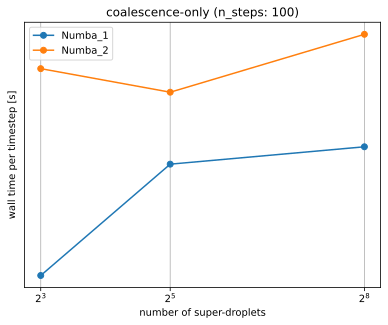

HTML(value="<a href='./tmpdvaspdky.pdf' target='_blank'>./tmpdvaspdky.pdf</a><br>")

In [12]:
plot_processed_results(coalescence_only_processed, plot_title=f'coalescence-only (n_steps: {n_steps})')

In [13]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}-coalescence-double-n_steps{n_steps}.txt"
write_to_file(filename=filename, d=coalescence_only_processed)

### Benchmark Breakup-only

In [14]:
res_breakup_only = go_benchmark(
    setup_breakup_only_sim, n_sds, n_steps, seeds, numba_n_threads=numba_n_threads, double_precision=True,
    general_filename=MY_SETUP_INFO_FILENAME+'-breakup',
    backends=[CPU]
)


 before

Numba_1 8

start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]
start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]
start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]

Numba_1 32

start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [32.]
start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [32.]
start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [32.]

Numba_1 256

start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [256.]
start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [256.]
start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [256.]

 before

Numba_2 8

start

 after
total_number [4.e+12]
total_volume [1000000.]
super_particle_count [8.]
start

 after
total_number [4.e+12]
total_volume [1000000.]
su

In [15]:
breakup_only_processed = process_results(res_breakup_only)

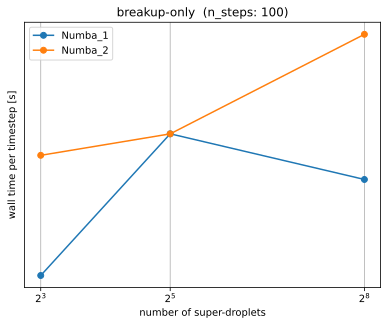

HTML(value="<a href='./tmpt1yxyd79.pdf' target='_blank'>./tmpt1yxyd79.pdf</a><br>")

In [16]:
plot_processed_results(breakup_only_processed, plot_title=f'breakup-only  (n_steps: {n_steps})')

In [17]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}-breakup-double-n_steps{n_steps}.txt"
write_to_file(filename=filename, d=breakup_only_processed)

### Coalescence and Breakup

In [18]:
n_steps = 2048


In [19]:
res_coal_breakup = go_benchmark(
    setup_coalescence_breakup_sim, n_sds, n_steps, seeds, numba_n_threads=numba_n_threads, double_precision=True, 
    general_filename=MY_SETUP_INFO_FILENAME+'-coal-break',
    backends=[CPU]
)


 before

Numba_1 8

start

 after
total_number [3286.]
total_volume [1000000.]
super_particle_count [8.]
start

 after
total_number [2858.]
total_volume [1000000.]
super_particle_count [8.]
start

 after
total_number [2487.]
total_volume [1000000.]
super_particle_count [8.]

Numba_1 32

start

 after
total_number [2233.]
total_volume [1000000.]
super_particle_count [32.]
start

 after
total_number [7016.]
total_volume [1000000.]
super_particle_count [32.]
start

 after
total_number [48480.]
total_volume [1000000.]
super_particle_count [32.]

Numba_1 256

start

 after
total_number [2.11263329e+09]
total_volume [1000000.]
super_particle_count [250.]
start

 after
total_number [30383.]
total_volume [1000000.]
super_particle_count [252.]
start

 after
total_number [3.6945636e+10]
total_volume [1000000.]
super_particle_count [255.]

 before

Numba_2 8

start

 after
total_number [3286.]
total_volume [1000000.]
super_particle_count [8.]
start

 after
total_number [2858.]
total_volume [1000

In [20]:
coal_breakup_processed = process_results(res_coal_breakup)

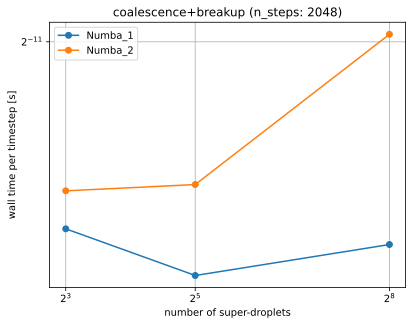

HTML(value="<a href='./tmp4vczjf4q.pdf' target='_blank'>./tmp4vczjf4q.pdf</a><br>")

In [23]:
plot_processed_results(coal_breakup_processed, plot_title=f'coalescence+breakup (n_steps: {n_steps})')

In [22]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}-coal+breakup-double-n_steps{n_steps}.txt"
write_to_file(filename=filename, d=coal_breakup_processed)

## Write to file

In [ ]:
d = {'coalescence': coalescence_only_processed, 'breakup': breakup_only_processed, 'coalescence+breakup': coal_breakup_processed}

In [ ]:
filename=f"{MY_SETUP_INFO_FILENAME}-results-{TIMESTAMP}"
write_to_file(filename=filename, d=d)



In [1]:
import numpy as np
import time

In [2]:
from numba import njit, prange
import numba
numba.get_num_threads()

8

In [81]:
@njit
def f(i, arr):
    for j in range(1_000):
        arr[i] /= 23423948129 * (j+1)
        arr[i] += j**12
        arr[i] -= 3737 * 787 * 28

In [86]:
N = 1600

def g_seq():
    arr = np.random.rand(N)

    for i in range(N):
        f(i, arr)

@njit(parallel=True)
def g_par():
    arr = np.random.rand(N)

    for i in prange(N):
        f(i, arr)

In [87]:
t0 = time.time()
g_seq()
t1 = time.time()
print('elapsed seq', t1-t0, 's')

t0 = time.time()
g_seq()
t1 = time.time()

seq_time = t1-t0

print('elapsed seq', seq_time, 's')



elapsed seq 0.018127918243408203 s
elapsed seq 0.014945030212402344 s


In [88]:
t0 = time.time()
g_par()
t1 = time.time()
print('elapsed par', t1-t0, 's')

t0 = time.time()
g_par()
t1 = time.time()

par_time = t1-t0
print('elapsed par', par_time, 's')



elapsed par 0.43813037872314453 s
elapsed par 0.0018100738525390625 s


In [89]:
seq_time / par_time

8.256585879873551